In [53]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline

In [54]:
np.random.seed(42)

In [55]:
import os
key=os.getenv("IEX_PUBLIC_KEY")
print(type(key))
key[-2]

<class 'str'>


'a'

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [56]:
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [57]:
list_of_tickers = ["SPY", "AGG"]
ticker = "SPY"
ticker2 = "AGG"

end_date = datetime.now()
start_date = end_date + timedelta(-1825)
#WILL ONLY GIVE US 5 YEARS OF DATA 365*5=1825
df = get_historical_data(list_of_tickers, start_date, end_date,  output_format='pandas',token=key)
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPY,AGG
,close,close
date,,
2014-10-03,196.52,109.30
2014-10-06,196.29,109.40
2014-10-07,193.26,109.82
2014-10-08,196.64,110.13
2014-10-09,192.74,109.91


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [58]:
#daily returns
daily_returns = df.pct_change()
daily_returns.head()

,SPY,AGG
,close,close
date,,
2014-10-03,NaN,NaN
2014-10-06,-0.001170,0.000915
2014-10-07,-0.015436,0.003839
2014-10-08,0.017489,0.002823
2014-10-09,-0.019833,-0.001998


In [59]:
#Avg daily return
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg

2.9414517849512197e-05

In [60]:
#volatility
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.00203174401139897

In [61]:
#Last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [62]:
# Setup the Monte Carlo Parameters
num_simulations = 100
number_trading_days = 252 * 30
monte_carlo = pd.DataFrame()

In [63]:
# Run the Monte Carlo Simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
# Run the simulation of projecting stock prices for the next trading year
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    # Simulate the returns for 252 days
    for i in range(number_trading_days):
         # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
        
  # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
     # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
     # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]
    
      # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
     # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
# Print records from the DataFrame
portfolio_cumulative_returns.head()
    

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002687,0.995008,0.992379,0.999147,1.005459,1.007288,1.009945,0.995318,1.001606,0.998848,...,1.001001,1.001470,0.994473,1.001611,0.992293,0.997064,1.008991,1.009687,1.007438,1.010291
2,1.007518,0.998796,0.991146,0.997927,1.008732,0.997042,1.003616,0.983564,1.000399,1.007757,...,0.996905,1.004897,0.987149,0.996495,0.990874,0.992527,1.001926,1.010515,1.005575,1.014117
3,1.006331,0.998522,0.994649,0.991237,1.007724,1.000220,1.007420,0.976849,0.999827,1.016176,...,1.002799,1.001997,0.979661,1.001530,0.987418,0.993144,0.996135,1.011156,1.006911,1.021651
4,1.015420,1.001300,0.990314,0.997140,1.008892,0.994355,1.005621,0.973653,1.008069,1.004649,...,1.008064,0.999822,0.978613,1.005421,0.980420,0.995345,0.987042,1.012059,1.010429,1.016700


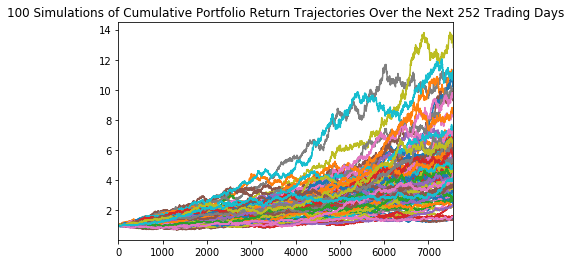

In [64]:
# Visualize the Simulation
# Use the `plot` function to plot `100` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [65]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    5.798898
1    4.700551
2    6.651307
3    7.074038
4    6.328687
Name: 7560, dtype: float64

In [66]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns20 = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns20.tail()

95    3.716366
96    4.349244
97    6.712638
98    6.500778
99    4.130432
Name: 7560, dtype: float64

In [67]:
# Display the 90% confidence interval for the ending returns
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    2.204876
0.95    9.678197
Name: 7560, dtype: float64

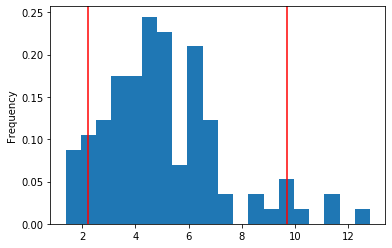

In [68]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [69]:
# YOUR CODE HERE
p10 = np.percentile(ending_cumulative_returns, 10)
p50 = np.percentile(ending_cumulative_returns, 50)
p90 = np.percentile(ending_cumulative_returns, 90)
print(p10)
print(p50)
print(p90)

2.4823177258346303
4.715509551574442
7.55178193793942


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [70]:
original = 20000

portfolio_10 = original + (original * p10)

portfolio_50 = original + (original * p50)

portfolio_90 = original + (original * p90)

print(portfolio_10)
print(portfolio_50)
print(portfolio_90)

69646.3545166926
114310.19103148884
171035.6387587884


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [71]:
withdraw = 0.04 *portfolio_10 

print('A 4% Withdraw will equal $2785.85')

a 4% Withdraw will equal $2785.85


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [72]:
new_original=30000

newp10 = new_original + (new_original * p10)

newp50 = new_original + (new_original * p50)

newp90 = new_original + (new_original * p90)

new_withdraw = newp10 * 0.04
new_withdraw
print(f'A 50% increase in the initial investment would essentially double the 4% retirement withdrawl to ${new_withdraw}')

A 50% increase in the initial investment would essentially double the 4% retirement withdrawl to $4178.781271001556


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE